In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout

from tqdm import tqdm
from joblib import dump, load

In [2]:
df = pd.read_csv("heloc_processed.csv")

In [3]:
df = df.drop(df.columns[0], axis=1)

In [4]:
df

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55.0,144.0,2.321928,84,20,3,83,2.0,3,...,1,43,0.0,0,33.0,NaN,8.0,1.0,1.0,69.0
1,1,61.0,58.0,4.000000,41,2,4,100,NaN,0,...,0,67,0.0,0,0.0,NaN,0.0,NaN,NaN,0.0
2,1,67.0,66.0,2.584963,24,9,0,100,NaN,7,...,4,44,0.0,4,53.0,66.0,4.0,2.0,1.0,86.0
3,1,66.0,169.0,1.000000,73,28,1,93,76.0,6,...,3,57,0.0,5,72.0,83.0,6.0,4.0,3.0,91.0
4,1,81.0,333.0,4.807355,132,12,0,100,NaN,7,...,0,25,0.0,1,51.0,89.0,3.0,1.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,0,73.0,131.0,2.584963,57,21,0,95,80.0,6,...,5,19,7.0,0,26.0,NaN,5.0,2.0,0.0,100.0
9835,1,65.0,147.0,5.321928,68,11,0,92,28.0,6,...,0,42,1.0,1,86.0,53.0,2.0,2.0,1.0,80.0
9836,1,74.0,129.0,2.807355,64,18,1,100,NaN,6,...,1,33,3.0,4,6.0,NaN,5.0,NaN,0.0,56.0
9837,1,72.0,234.0,3.700440,113,42,2,96,35.0,6,...,0,20,6.0,0,19.0,NaN,4.0,1.0,0.0,38.0


## RandomForestClassifier

Progreso: 100%|██████████| 20/20 [02:40<00:00,  8.04s/it]


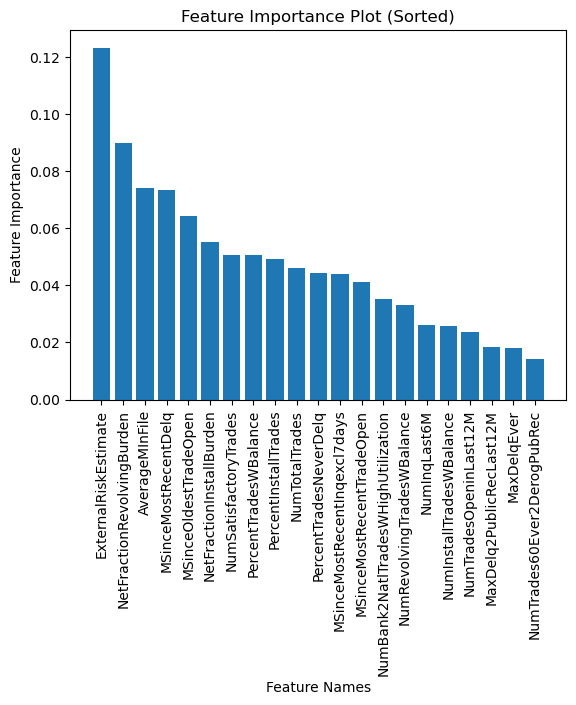

Modelo: RandomForestClassifier(random_state=42)
Vecinos: 5
Precision: 0.7323193916349809
Recall: 0.7524907208439148
F1 Score: 0.7422680412371134
Accuracy: 0.7281227767049497
AUC: 0.727092818049076
Modelo guardado como 'modelo_rfc.joblib'


In [5]:
best_results = {"Modelo": None, "Precision": 0 ,"Accuracy": 0, "Recall": 0, "F1": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    imputer = KNNImputer(n_neighbors=neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    X = df_imputed.drop(["RiskPerformance"], axis=1)
    y = df_imputed["RiskPerformance"]

    model = RandomForestClassifier(random_state=42)

    cv_predictions = cross_val_predict(model, X, y, cv=5)

    avg_precision = precision_score(y, cv_predictions)
    avg_accuracy  = accuracy_score(y, cv_predictions)
    avg_recall    = recall_score(y, cv_predictions)
    avg_auc       = roc_auc_score(y, cv_predictions)
    avg_f1        = f1_score(y, cv_predictions)

    if avg_precision > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1"]        = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors

best_model = best_results["Modelo"]
best_model.fit(X, y)
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*feature_importance_sorted)

plt.bar(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot (Sorted)')
plt.xticks(rotation=90)
plt.show()


dump(best_model, 'modelo_rfc.joblib')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_rfc.joblib'")

## Red StandardScaler

In [6]:
tf.random.set_seed(42)

best_results = {"Modelo": None, "Precision": 0, "Recall": 0,  "Accuracy": 0, "F1_Score": 0, "AUC": 0, "Vecinos": 0}

imputer = KNNImputer()

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    X = df_imputed.drop("RiskPerformance", axis=1)
    y = df_imputed["RiskPerformance"]

    X_scaled = StandardScaler().fit_transform(X)

    input_nodes  = X_scaled.shape[1]
    output_nodes = 1

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3, seed=0))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores, recall_scores, f1_scores, auc_scores, accuracy_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        history = model.fit(
            X_train,
            y_train,
            epochs=100,
            validation_data=(X_test, y_test),
            verbose=2
        )
    
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    
        precision = precision_score(y_test, y_pred)
        recall    = recall_score(y_test, y_pred)
        f1        = f1_score(y_test, y_pred)
        auc       = roc_auc_score(y_test, y_pred)
        accuracy  = accuracy_score(y_test, y_pred)
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)

        avg_precision = np.mean(precision_scores)
        avg_recall    = np.mean(recall_scores)
        avg_f1        = np.mean(f1_scores)
        avg_auc       = np.mean(auc_scores)
        avg_accuracy  = np.mean(accuracy_scores)

    if avg_f1 > best_results["F1_Score"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1_Score"]  = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        
best_results["Modelo"].save('modelo_red_neuronal_seq.h5')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1_Score"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_red_neuronal_seq.h5'")

Progreso:   0%|          | 0/20 [00:00<?, ?it/s]



Epoch 1/100

246/246 - 1s - loss: 0.1523 - val_loss: 0.1025 - 772ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1085 - val_loss: 0.0956 - 201ms/epoch - 817us/step
Epoch 3/100
246/246 - 0s - loss: 0.1007 - val_loss: 0.0921 - 198ms/epoch - 806us/step
Epoch 4/100
246/246 - 0s - loss: 0.0973 - val_loss: 0.0918 - 203ms/epoch - 827us/step
Epoch 5/100
246/246 - 0s - loss: 0.0967 - val_loss: 0.0913 - 200ms/epoch - 813us/step
Epoch 6/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0912 - 198ms/epoch - 805us/step
Epoch 7/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0915 - 198ms/epoch - 806us/step
Epoch 8/100
246/246 - 0s - loss: 0.0940 - val_loss: 0.0910 - 196ms/epoch - 798us/step
Epoch 9/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0908 - 198ms/epoch - 806us/step
Epoch 10/100
246/246 - 0s - loss: 0.0925 - val_loss: 0.0910 - 197ms/epoch - 801us/step
Epoch 11/100
246/246 - 0s - loss: 0.0924 - val_loss: 0.0912 - 197ms/epoch - 802us/step
Epoch 12/100
246/246 - 0s - loss: 0.0920 - val_loss

Progreso:   5%|▌         | 1/20 [01:45<33:22, 105.40s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1500 - val_loss: 0.1007 - 646ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1086 - val_loss: 0.0962 - 208ms/epoch - 844us/step
Epoch 3/100
246/246 - 0s - loss: 0.1022 - val_loss: 0.0943 - 200ms/epoch - 812us/step
Epoch 4/100
246/246 - 0s - loss: 0.0982 - val_loss: 0.0927 - 197ms/epoch - 801us/step
Epoch 5/100
246/246 - 0s - loss: 0.0959 - val_loss: 0.0936 - 198ms/epoch - 804us/step
Epoch 6/100
246/246 - 0s - loss: 0.0946 - val_loss: 0.0921 - 202ms/epoch - 821us/step
Epoch 7/100
246/246 - 0s - loss: 0.0940 - val_loss: 0.0930 - 203ms/epoch - 827us/step
Epoch 8/100
246/246 - 0s - loss: 0.0935 - val_loss: 0.0917 - 200ms/epoch - 812us/step
Epoch 9/100
246/246 - 0s - loss: 0.0924 - val_loss: 0.0919 - 201ms/epoch - 817us/step
Epoch 10/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0922 - 199ms/epoch - 808us/step
Epoch 11/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0922 - 198ms/epoch - 805us/step
Epoch 12/100
246/246 - 0s - loss: 0.0918 - val_loss: 0

Progreso:  10%|█         | 2/20 [03:34<32:11, 107.31s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1461 - val_loss: 0.0985 - 677ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1063 - val_loss: 0.0965 - 207ms/epoch - 841us/step
Epoch 3/100
246/246 - 0s - loss: 0.1002 - val_loss: 0.0924 - 206ms/epoch - 839us/step
Epoch 4/100
246/246 - 0s - loss: 0.0967 - val_loss: 0.0918 - 216ms/epoch - 877us/step
Epoch 5/100
246/246 - 0s - loss: 0.0952 - val_loss: 0.0919 - 210ms/epoch - 854us/step
Epoch 6/100
246/246 - 0s - loss: 0.0939 - val_loss: 0.0911 - 211ms/epoch - 857us/step
Epoch 7/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0916 - 210ms/epoch - 855us/step
Epoch 8/100
246/246 - 0s - loss: 0.0931 - val_loss: 0.0917 - 209ms/epoch - 849us/step
Epoch 9/100
246/246 - 0s - loss: 0.0926 - val_loss: 0.0909 - 214ms/epoch - 869us/step
Epoch 10/100
246/246 - 0s - loss: 0.0919 - val_loss: 0.0916 - 214ms/epoch - 868us/step
Epoch 11/100
246/246 - 0s - loss: 0.0911 - val_loss: 0.0911 - 214ms/epoch - 871us/step
Epoch 12/100
246/246 - 0s - loss: 0.0909 - val_loss: 0

Progreso:  15%|█▌        | 3/20 [05:23<30:38, 108.17s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1469 - val_loss: 0.1009 - 671ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1060 - val_loss: 0.0945 - 204ms/epoch - 829us/step
Epoch 3/100
246/246 - 0s - loss: 0.0996 - val_loss: 0.0934 - 207ms/epoch - 842us/step
Epoch 4/100
246/246 - 0s - loss: 0.0964 - val_loss: 0.0923 - 206ms/epoch - 837us/step
Epoch 5/100
246/246 - 0s - loss: 0.0941 - val_loss: 0.0925 - 205ms/epoch - 833us/step
Epoch 6/100
246/246 - 0s - loss: 0.0942 - val_loss: 0.0931 - 204ms/epoch - 828us/step
Epoch 7/100
246/246 - 0s - loss: 0.0926 - val_loss: 0.0927 - 205ms/epoch - 832us/step
Epoch 8/100
246/246 - 0s - loss: 0.0929 - val_loss: 0.0910 - 204ms/epoch - 828us/step
Epoch 9/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0915 - 203ms/epoch - 825us/step
Epoch 10/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0918 - 208ms/epoch - 844us/step
Epoch 11/100
246/246 - 0s - loss: 0.0916 - val_loss: 0.0918 - 204ms/epoch - 830us/step
Epoch 12/100
246/246 - 0s - loss: 0.0903 - val_loss: 0

Progreso:  20%|██        | 4/20 [07:12<28:54, 108.44s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1402 - val_loss: 0.0985 - 666ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1049 - val_loss: 0.0952 - 208ms/epoch - 847us/step
Epoch 3/100
246/246 - 0s - loss: 0.0991 - val_loss: 0.0930 - 210ms/epoch - 852us/step
Epoch 4/100
246/246 - 0s - loss: 0.0978 - val_loss: 0.0920 - 210ms/epoch - 852us/step
Epoch 5/100
246/246 - 0s - loss: 0.0949 - val_loss: 0.0928 - 217ms/epoch - 881us/step
Epoch 6/100
246/246 - 0s - loss: 0.0940 - val_loss: 0.0924 - 213ms/epoch - 866us/step
Epoch 7/100
246/246 - 0s - loss: 0.0934 - val_loss: 0.0920 - 207ms/epoch - 840us/step
Epoch 8/100
246/246 - 0s - loss: 0.0925 - val_loss: 0.0920 - 208ms/epoch - 847us/step
Epoch 9/100
246/246 - 0s - loss: 0.0919 - val_loss: 0.0919 - 209ms/epoch - 850us/step
Epoch 10/100
246/246 - 0s - loss: 0.0911 - val_loss: 0.0925 - 207ms/epoch - 841us/step
Epoch 11/100
246/246 - 0s - loss: 0.0915 - val_loss: 0.0921 - 208ms/epoch - 845us/step
Epoch 12/100
246/246 - 0s - loss: 0.0902 - val_loss: 0

Progreso:  25%|██▌       | 5/20 [09:01<27:09, 108.64s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1483 - val_loss: 0.0976 - 693ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1072 - val_loss: 0.0945 - 207ms/epoch - 839us/step
Epoch 3/100
246/246 - 0s - loss: 0.0995 - val_loss: 0.0926 - 206ms/epoch - 836us/step
Epoch 4/100
246/246 - 0s - loss: 0.0971 - val_loss: 0.0919 - 204ms/epoch - 831us/step
Epoch 5/100
246/246 - 0s - loss: 0.0954 - val_loss: 0.0916 - 204ms/epoch - 831us/step
Epoch 6/100
246/246 - 0s - loss: 0.0944 - val_loss: 0.0913 - 206ms/epoch - 836us/step
Epoch 7/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0915 - 206ms/epoch - 836us/step
Epoch 8/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0915 - 205ms/epoch - 834us/step
Epoch 9/100
246/246 - 0s - loss: 0.0921 - val_loss: 0.0905 - 203ms/epoch - 825us/step
Epoch 10/100
246/246 - 0s - loss: 0.0920 - val_loss: 0.0917 - 206ms/epoch - 838us/step
Epoch 11/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0912 - 206ms/epoch - 836us/step
Epoch 12/100
246/246 - 0s - loss: 0.0918 - val_loss: 0

Progreso:  30%|███       | 6/20 [10:50<25:23, 108.79s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1325 - val_loss: 0.1012 - 680ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1029 - val_loss: 0.0951 - 209ms/epoch - 849us/step
Epoch 3/100
246/246 - 0s - loss: 0.0974 - val_loss: 0.0931 - 203ms/epoch - 824us/step
Epoch 4/100
246/246 - 0s - loss: 0.0952 - val_loss: 0.0922 - 205ms/epoch - 835us/step
Epoch 5/100
246/246 - 0s - loss: 0.0947 - val_loss: 0.0927 - 210ms/epoch - 852us/step
Epoch 6/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0920 - 208ms/epoch - 844us/step
Epoch 7/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0923 - 207ms/epoch - 840us/step
Epoch 8/100
246/246 - 0s - loss: 0.0937 - val_loss: 0.0914 - 215ms/epoch - 872us/step
Epoch 9/100
246/246 - 0s - loss: 0.0926 - val_loss: 0.0909 - 203ms/epoch - 824us/step
Epoch 10/100
246/246 - 0s - loss: 0.0912 - val_loss: 0.0915 - 212ms/epoch - 864us/step
Epoch 11/100
246/246 - 0s - loss: 0.0913 - val_loss: 0.0922 - 213ms/epoch - 866us/step
Epoch 12/100
246/246 - 0s - loss: 0.0906 - val_loss: 0

Progreso:  35%|███▌      | 7/20 [12:39<23:35, 108.87s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1275 - val_loss: 0.1040 - 670ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1041 - val_loss: 0.0992 - 206ms/epoch - 838us/step
Epoch 3/100
246/246 - 0s - loss: 0.0988 - val_loss: 0.0944 - 213ms/epoch - 868us/step
Epoch 4/100
246/246 - 0s - loss: 0.0963 - val_loss: 0.0936 - 206ms/epoch - 836us/step
Epoch 5/100
246/246 - 0s - loss: 0.0954 - val_loss: 0.0936 - 205ms/epoch - 835us/step
Epoch 6/100
246/246 - 0s - loss: 0.0947 - val_loss: 0.0937 - 207ms/epoch - 841us/step
Epoch 7/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0951 - 205ms/epoch - 833us/step
Epoch 8/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0932 - 207ms/epoch - 842us/step
Epoch 9/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0918 - 202ms/epoch - 820us/step
Epoch 10/100
246/246 - 0s - loss: 0.0914 - val_loss: 0.0918 - 207ms/epoch - 843us/step
Epoch 11/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0926 - 219ms/epoch - 892us/step
Epoch 12/100
246/246 - 0s - loss: 0.0902 - val_loss: 0

Progreso:  40%|████      | 8/20 [14:28<21:47, 108.99s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1648 - val_loss: 0.0956 - 664ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1099 - val_loss: 0.0956 - 206ms/epoch - 837us/step
Epoch 3/100
246/246 - 0s - loss: 0.1017 - val_loss: 0.0956 - 207ms/epoch - 842us/step
Epoch 4/100
246/246 - 0s - loss: 0.0985 - val_loss: 0.0931 - 204ms/epoch - 831us/step
Epoch 5/100
246/246 - 0s - loss: 0.0966 - val_loss: 0.0934 - 216ms/epoch - 876us/step
Epoch 6/100
246/246 - 0s - loss: 0.0949 - val_loss: 0.0927 - 208ms/epoch - 845us/step
Epoch 7/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0942 - 206ms/epoch - 839us/step
Epoch 8/100
246/246 - 0s - loss: 0.0952 - val_loss: 0.0938 - 205ms/epoch - 834us/step
Epoch 9/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0912 - 205ms/epoch - 835us/step
Epoch 10/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0924 - 205ms/epoch - 831us/step
Epoch 11/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0916 - 207ms/epoch - 841us/step
Epoch 12/100
246/246 - 0s - loss: 0.0914 - val_loss: 0

Progreso:  45%|████▌     | 9/20 [16:17<19:59, 109.04s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1279 - val_loss: 0.1005 - 677ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1044 - val_loss: 0.0957 - 208ms/epoch - 845us/step
Epoch 3/100
246/246 - 0s - loss: 0.0997 - val_loss: 0.0923 - 209ms/epoch - 848us/step
Epoch 4/100
246/246 - 0s - loss: 0.0965 - val_loss: 0.0920 - 205ms/epoch - 835us/step
Epoch 5/100
246/246 - 0s - loss: 0.0946 - val_loss: 0.0914 - 210ms/epoch - 852us/step
Epoch 6/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0910 - 208ms/epoch - 846us/step
Epoch 7/100
246/246 - 0s - loss: 0.0932 - val_loss: 0.0918 - 207ms/epoch - 842us/step
Epoch 8/100
246/246 - 0s - loss: 0.0922 - val_loss: 0.0908 - 209ms/epoch - 851us/step
Epoch 9/100
246/246 - 0s - loss: 0.0912 - val_loss: 0.0905 - 205ms/epoch - 834us/step
Epoch 10/100
246/246 - 0s - loss: 0.0911 - val_loss: 0.0904 - 207ms/epoch - 842us/step
Epoch 11/100
246/246 - 0s - loss: 0.0910 - val_loss: 0.0907 - 205ms/epoch - 834us/step
Epoch 12/100
246/246 - 0s - loss: 0.0909 - val_loss: 0

Progreso:  50%|█████     | 10/20 [18:06<18:11, 109.12s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1449 - val_loss: 0.1062 - 663ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1081 - val_loss: 0.0976 - 208ms/epoch - 847us/step
Epoch 3/100
246/246 - 0s - loss: 0.1001 - val_loss: 0.0930 - 205ms/epoch - 833us/step
Epoch 4/100
246/246 - 0s - loss: 0.0984 - val_loss: 0.0922 - 205ms/epoch - 832us/step
Epoch 5/100
246/246 - 0s - loss: 0.0951 - val_loss: 0.0933 - 202ms/epoch - 820us/step
Epoch 6/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0907 - 204ms/epoch - 829us/step
Epoch 7/100
246/246 - 0s - loss: 0.0935 - val_loss: 0.0929 - 204ms/epoch - 829us/step
Epoch 8/100
246/246 - 0s - loss: 0.0939 - val_loss: 0.0915 - 207ms/epoch - 842us/step
Epoch 9/100
246/246 - 0s - loss: 0.0925 - val_loss: 0.0911 - 213ms/epoch - 866us/step
Epoch 10/100
246/246 - 0s - loss: 0.0922 - val_loss: 0.0910 - 207ms/epoch - 843us/step
Epoch 11/100
246/246 - 0s - loss: 0.0915 - val_loss: 0.0917 - 206ms/epoch - 836us/step
Epoch 12/100
246/246 - 0s - loss: 0.0912 - val_loss: 0

Progreso:  55%|█████▌    | 11/20 [19:55<16:20, 108.94s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1559 - val_loss: 0.0975 - 663ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1089 - val_loss: 0.0948 - 203ms/epoch - 825us/step
Epoch 3/100
246/246 - 0s - loss: 0.0998 - val_loss: 0.0935 - 200ms/epoch - 813us/step
Epoch 4/100
246/246 - 0s - loss: 0.0974 - val_loss: 0.0937 - 203ms/epoch - 824us/step
Epoch 5/100
246/246 - 0s - loss: 0.0955 - val_loss: 0.0914 - 200ms/epoch - 814us/step
Epoch 6/100
246/246 - 0s - loss: 0.0961 - val_loss: 0.0917 - 211ms/epoch - 858us/step
Epoch 7/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0911 - 209ms/epoch - 850us/step
Epoch 8/100
246/246 - 0s - loss: 0.0934 - val_loss: 0.0915 - 212ms/epoch - 863us/step
Epoch 9/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0909 - 212ms/epoch - 861us/step
Epoch 10/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0909 - 206ms/epoch - 837us/step
Epoch 11/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0905 - 203ms/epoch - 825us/step
Epoch 12/100
246/246 - 0s - loss: 0.0908 - val_loss: 0

Progreso:  60%|██████    | 12/20 [21:42<14:26, 108.31s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1392 - val_loss: 0.1022 - 661ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1064 - val_loss: 0.0966 - 201ms/epoch - 816us/step
Epoch 3/100
246/246 - 0s - loss: 0.0991 - val_loss: 0.0947 - 206ms/epoch - 838us/step
Epoch 4/100
246/246 - 0s - loss: 0.0982 - val_loss: 0.0929 - 213ms/epoch - 864us/step
Epoch 5/100
246/246 - 0s - loss: 0.0955 - val_loss: 0.0935 - 203ms/epoch - 825us/step
Epoch 6/100
246/246 - 0s - loss: 0.0950 - val_loss: 0.0933 - 205ms/epoch - 833us/step
Epoch 7/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0939 - 201ms/epoch - 816us/step
Epoch 8/100
246/246 - 0s - loss: 0.0934 - val_loss: 0.0925 - 205ms/epoch - 834us/step
Epoch 9/100
246/246 - 0s - loss: 0.0933 - val_loss: 0.0919 - 202ms/epoch - 820us/step
Epoch 10/100
246/246 - 0s - loss: 0.0924 - val_loss: 0.0924 - 204ms/epoch - 827us/step
Epoch 11/100
246/246 - 0s - loss: 0.0914 - val_loss: 0.0921 - 205ms/epoch - 835us/step
Epoch 12/100
246/246 - 0s - loss: 0.0917 - val_loss: 0

Progreso:  65%|██████▌   | 13/20 [23:29<12:36, 108.01s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1422 - val_loss: 0.0949 - 661ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1066 - val_loss: 0.0929 - 209ms/epoch - 848us/step
Epoch 3/100
246/246 - 0s - loss: 0.1002 - val_loss: 0.0923 - 213ms/epoch - 864us/step
Epoch 4/100
246/246 - 0s - loss: 0.0966 - val_loss: 0.0914 - 206ms/epoch - 839us/step
Epoch 5/100
246/246 - 0s - loss: 0.0965 - val_loss: 0.0921 - 207ms/epoch - 842us/step
Epoch 6/100
246/246 - 0s - loss: 0.0952 - val_loss: 0.0908 - 208ms/epoch - 846us/step
Epoch 7/100
246/246 - 0s - loss: 0.0929 - val_loss: 0.0918 - 205ms/epoch - 833us/step
Epoch 8/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0923 - 203ms/epoch - 826us/step
Epoch 9/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0914 - 207ms/epoch - 842us/step
Epoch 10/100
246/246 - 0s - loss: 0.0920 - val_loss: 0.0909 - 206ms/epoch - 839us/step
Epoch 11/100
246/246 - 0s - loss: 0.0914 - val_loss: 0.0911 - 208ms/epoch - 846us/step
Epoch 12/100
246/246 - 0s - loss: 0.0915 - val_loss: 0

Progreso:  70%|███████   | 14/20 [25:17<10:48, 108.12s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1305 - val_loss: 0.0961 - 666ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1011 - val_loss: 0.0938 - 213ms/epoch - 867us/step
Epoch 3/100
246/246 - 0s - loss: 0.0976 - val_loss: 0.0915 - 206ms/epoch - 837us/step
Epoch 4/100
246/246 - 0s - loss: 0.0942 - val_loss: 0.0908 - 205ms/epoch - 832us/step
Epoch 5/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0906 - 207ms/epoch - 842us/step
Epoch 6/100
246/246 - 0s - loss: 0.0924 - val_loss: 0.0908 - 205ms/epoch - 831us/step
Epoch 7/100
246/246 - 0s - loss: 0.0919 - val_loss: 0.0911 - 205ms/epoch - 835us/step
Epoch 8/100
246/246 - 0s - loss: 0.0919 - val_loss: 0.0902 - 206ms/epoch - 839us/step
Epoch 9/100
246/246 - 0s - loss: 0.0921 - val_loss: 0.0900 - 206ms/epoch - 836us/step
Epoch 10/100
246/246 - 0s - loss: 0.0906 - val_loss: 0.0906 - 209ms/epoch - 851us/step
Epoch 11/100
246/246 - 0s - loss: 0.0906 - val_loss: 0.0911 - 206ms/epoch - 837us/step
Epoch 12/100
246/246 - 0s - loss: 0.0902 - val_loss: 0

Progreso:  75%|███████▌  | 15/20 [27:08<09:04, 108.84s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1430 - val_loss: 0.1033 - 698ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1076 - val_loss: 0.0970 - 218ms/epoch - 884us/step
Epoch 3/100
246/246 - 0s - loss: 0.1009 - val_loss: 0.0946 - 234ms/epoch - 951us/step
Epoch 4/100
246/246 - 0s - loss: 0.0978 - val_loss: 0.0920 - 224ms/epoch - 909us/step
Epoch 5/100
246/246 - 0s - loss: 0.0960 - val_loss: 0.0919 - 215ms/epoch - 876us/step
Epoch 6/100
246/246 - 0s - loss: 0.0950 - val_loss: 0.0916 - 219ms/epoch - 890us/step
Epoch 7/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0919 - 209ms/epoch - 848us/step
Epoch 8/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0915 - 213ms/epoch - 864us/step
Epoch 9/100
246/246 - 0s - loss: 0.0932 - val_loss: 0.0907 - 216ms/epoch - 878us/step
Epoch 10/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0919 - 216ms/epoch - 878us/step
Epoch 11/100
246/246 - 0s - loss: 0.0920 - val_loss: 0.0921 - 210ms/epoch - 854us/step
Epoch 12/100
246/246 - 0s - loss: 0.0907 - val_loss: 0

Progreso:  80%|████████  | 16/20 [29:02<07:22, 110.51s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1564 - val_loss: 0.1009 - 737ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1087 - val_loss: 0.0959 - 225ms/epoch - 914us/step
Epoch 3/100
246/246 - 0s - loss: 0.1014 - val_loss: 0.0939 - 223ms/epoch - 906us/step
Epoch 4/100
246/246 - 0s - loss: 0.0977 - val_loss: 0.0927 - 216ms/epoch - 878us/step
Epoch 5/100
246/246 - 0s - loss: 0.0960 - val_loss: 0.0918 - 229ms/epoch - 931us/step
Epoch 6/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0921 - 218ms/epoch - 887us/step
Epoch 7/100
246/246 - 0s - loss: 0.0943 - val_loss: 0.0921 - 223ms/epoch - 907us/step
Epoch 8/100
246/246 - 0s - loss: 0.0938 - val_loss: 0.0913 - 216ms/epoch - 878us/step
Epoch 9/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0914 - 216ms/epoch - 876us/step
Epoch 10/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0915 - 228ms/epoch - 927us/step
Epoch 11/100
246/246 - 0s - loss: 0.0915 - val_loss: 0.0919 - 241ms/epoch - 980us/step
Epoch 12/100
246/246 - 0s - loss: 0.0916 - val_loss: 0

Progreso:  85%|████████▌ | 17/20 [30:55<05:33, 111.28s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1320 - val_loss: 0.0994 - 663ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1040 - val_loss: 0.0969 - 202ms/epoch - 822us/step
Epoch 3/100
246/246 - 0s - loss: 0.1006 - val_loss: 0.0937 - 206ms/epoch - 836us/step
Epoch 4/100
246/246 - 0s - loss: 0.0961 - val_loss: 0.0930 - 206ms/epoch - 836us/step
Epoch 5/100
246/246 - 0s - loss: 0.0954 - val_loss: 0.0926 - 205ms/epoch - 833us/step
Epoch 6/100
246/246 - 0s - loss: 0.0947 - val_loss: 0.0922 - 204ms/epoch - 831us/step
Epoch 7/100
246/246 - 0s - loss: 0.0941 - val_loss: 0.0925 - 208ms/epoch - 844us/step
Epoch 8/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0912 - 211ms/epoch - 859us/step
Epoch 9/100
246/246 - 0s - loss: 0.0929 - val_loss: 0.0912 - 202ms/epoch - 821us/step
Epoch 10/100
246/246 - 0s - loss: 0.0922 - val_loss: 0.0921 - 203ms/epoch - 826us/step
Epoch 11/100
246/246 - 0s - loss: 0.0915 - val_loss: 0.0912 - 205ms/epoch - 835us/step
Epoch 12/100
246/246 - 0s - loss: 0.0911 - val_loss: 0

Progreso:  90%|█████████ | 18/20 [32:45<03:41, 110.64s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1524 - val_loss: 0.1040 - 670ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1114 - val_loss: 0.1001 - 213ms/epoch - 865us/step
Epoch 3/100
246/246 - 0s - loss: 0.1031 - val_loss: 0.0956 - 206ms/epoch - 836us/step
Epoch 4/100
246/246 - 0s - loss: 0.0992 - val_loss: 0.0962 - 207ms/epoch - 841us/step
Epoch 5/100
246/246 - 0s - loss: 0.0963 - val_loss: 0.0958 - 212ms/epoch - 860us/step
Epoch 6/100
246/246 - 0s - loss: 0.0953 - val_loss: 0.0936 - 205ms/epoch - 835us/step
Epoch 7/100
246/246 - 0s - loss: 0.0949 - val_loss: 0.0947 - 204ms/epoch - 828us/step
Epoch 8/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0929 - 209ms/epoch - 849us/step
Epoch 9/100
246/246 - 0s - loss: 0.0932 - val_loss: 0.0914 - 215ms/epoch - 873us/step
Epoch 10/100
246/246 - 0s - loss: 0.0923 - val_loss: 0.0916 - 217ms/epoch - 883us/step
Epoch 11/100
246/246 - 0s - loss: 0.0918 - val_loss: 0.0918 - 210ms/epoch - 853us/step
Epoch 12/100
246/246 - 0s - loss: 0.0913 - val_loss: 0

Progreso:  95%|█████████▌| 19/20 [34:35<01:50, 110.49s/it]

Epoch 1/100
246/246 - 1s - loss: 0.1461 - val_loss: 0.1000 - 684ms/epoch - 3ms/step
Epoch 2/100
246/246 - 0s - loss: 0.1065 - val_loss: 0.0952 - 220ms/epoch - 895us/step
Epoch 3/100
246/246 - 0s - loss: 0.0999 - val_loss: 0.0930 - 209ms/epoch - 851us/step
Epoch 4/100
246/246 - 0s - loss: 0.0975 - val_loss: 0.0920 - 207ms/epoch - 841us/step
Epoch 5/100
246/246 - 0s - loss: 0.0955 - val_loss: 0.0920 - 208ms/epoch - 844us/step
Epoch 6/100
246/246 - 0s - loss: 0.0946 - val_loss: 0.0922 - 213ms/epoch - 866us/step
Epoch 7/100
246/246 - 0s - loss: 0.0930 - val_loss: 0.0936 - 219ms/epoch - 890us/step
Epoch 8/100
246/246 - 0s - loss: 0.0936 - val_loss: 0.0916 - 215ms/epoch - 872us/step
Epoch 9/100
246/246 - 0s - loss: 0.0928 - val_loss: 0.0912 - 218ms/epoch - 886us/step
Epoch 10/100
246/246 - 0s - loss: 0.0922 - val_loss: 0.0913 - 215ms/epoch - 872us/step
Epoch 11/100
246/246 - 0s - loss: 0.0919 - val_loss: 0.0912 - 210ms/epoch - 852us/step
Epoch 12/100
246/246 - 0s - loss: 0.0909 - val_loss: 0

Progreso: 100%|██████████| 20/20 [36:26<00:00, 109.32s/it]

Modelo: <keras.src.engine.sequential.Sequential object at 0x0000027711105610>
Vecinos: 13
Precision: 0.7672980921595892
Recall: 0.7603070778347997
F1 Score: 0.76374669157
Accuracy: 0.7551598323558224
AUC: 0.7549416745106201
Modelo guardado como 'modelo_red_neuronal_seq.h5'



C:\Users\Adri1\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Carga Modelos

In [7]:
load('modelo_rfc.joblib')

RandomForestClassifier(random_state=42)

In [8]:
load('modelo_red_neuronal_mlp.joblib')

MLPClassifier(max_iter=500, random_state=42)

In [9]:
load_model('modelo_red_neuronal_seq.h5')